# What Makes a Magic: The Gathering Card Valuable? A Data-Driven Analysis of Card Features, Mana Cost, Usage and Scarcity.

By David Byrne.

## Introduction: Firstly, what is Magic: The Gathering? 

Magic: The Gathering - which I will refer to throughout this project as MTG or *Magic* - is a collectible trading card game. In the game, players amass cards and assemble them into decks, which they use to play against other players.This is a *gross* over-simplification of the game - in fact, MIT considers Magic to be ["officially the world's most complex game."](https://www.technologyreview.com/2019/05/07/135482/magic-the-gathering-is-officially-the-worlds-most-complex-game/) We're not going to delve into all of the complexities here, instead, this project is going to focus on a very specific aspect of this game: its economy.

## Part One: Card Features and Mana Costs



### Preparing the Data

**MTGJSON**
> The data used in this project was provided by `MTGJSON`, an open-source project that catalogs all Magic the Gathering data into portable formats.





The Modern Horizons 3 dataset was loaded from a JSON file containing metadata about the set and the cards themselves. Only card objects were exported and converted into a Pandas DataFrame to be used for analysis.

The `manaValue` attribute was selected as it is one of the most important numerical features in MtG. *Mana* is effectively the in-game cost of playing a card. Cards known as Lands or Mana Rocks are played onto the board, then tapped to generate mana. Once enough mana is generated, a card can be played equal to the converted mana cost of the card.



Mana value is important for a number of reasons with MtG. It usually is an indication of the power level of an individual card. Lower mana value cards generally are flexible -  -


In [46]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

with open("data/raw/mh3.json", "r", encoding="utf-8") as f:
    mh3_data = json.load(f)

cards = mh3_data["data"]["cards"]

type(cards), len(cards)



(list, 564)

In [47]:
mh3_df = pd.DataFrame(cards)
mh3_df.head()
mh3_df.columns

# dataframe saved and works correctly

Index(['artist', 'artistIds', 'availability', 'boosterTypes', 'borderColor',
       'colorIdentity', 'colors', 'convertedManaCost', 'edhrecRank',
       'edhrecSaltiness', 'finishes', 'flavorText', 'foreignData',
       'frameVersion', 'hasFoil', 'hasNonFoil', 'identifiers', 'keywords',
       'language', 'layout', 'legalities', 'manaCost', 'manaValue', 'name',
       'number', 'originalText', 'power', 'printings', 'purchaseUrls',
       'rarity', 'rulings', 'setCode', 'sourceProducts', 'subtypes',
       'supertypes', 'text', 'toughness', 'type', 'types', 'uuid', 'isFullArt',
       'securityStamp', 'variations', 'frameEffects', 'leadershipSkills',
       'rebalancedPrintings', 'isAlternative', 'isOnlineOnly', 'isRebalanced',
       'isStarter', 'originalPrintings', 'originalReleaseDate', 'promoTypes',
       'asciiName', 'faceConvertedManaCost', 'faceManaValue', 'faceName',
       'otherFaceIds', 'side', 'isReprint', 'colorIndicator', 'loyalty',
       'watermark', 'isPromo'],
      

In [48]:
mana_values = mh3_df['manaValue'].dropna()
counts = mana_values.value_counts().sort_index()
print(counts)

two_mana_count = counts.loc[2]
print(f"Number of cards with mana value of 2: {two_mana_count}")

manaValue
0.0     100
1.0      56
2.0     152
3.0     114
4.0      68
5.0      22
6.0      14
7.0      14
8.0       6
9.0       8
10.0      5
12.0      5
Name: count, dtype: int64
Number of cards with mana value of 2: 152


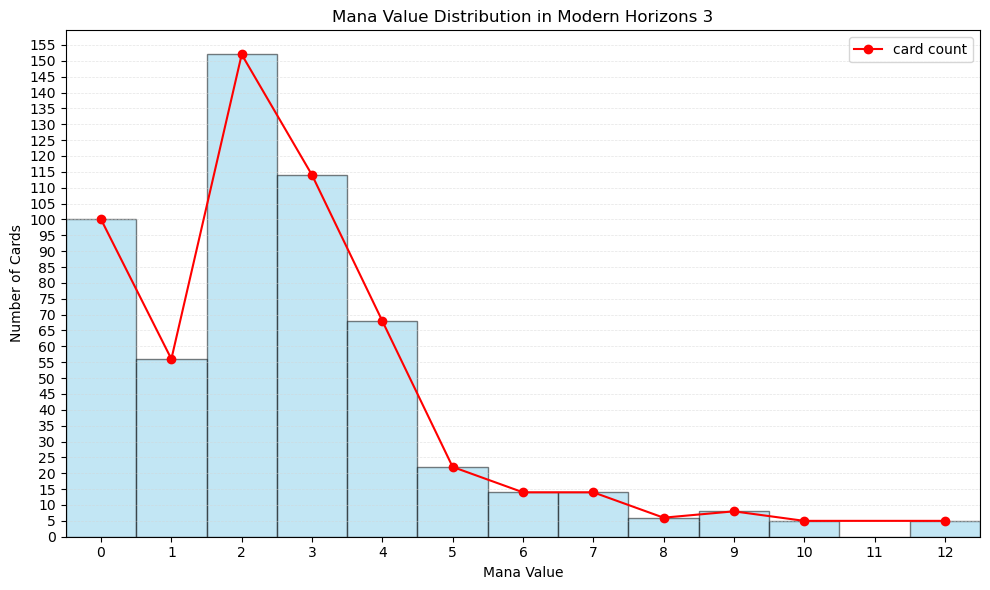

In [49]:
# Mana Value Histogram

plt.figure(figsize=(10,6))
plt.hist(
    mana_values,
    bins=range(int(mana_values.min()), int(mana_values.max()) + 2),
    edgecolor='black',
    color='skyblue',
    alpha=0.5,
    align='left'
)

plt.plot(
    counts.index, 
    counts.values, 
    marker='o', 
    color='red',
    label='card count')

plt.margins(x=0)
plt.title('Mana Value Distribution in Modern Horizons 3')
plt.xlabel('Mana Value')
plt.ylabel('Number of Cards')
plt.grid(axis='y', linestyle='--', alpha=0.6, color='lightgray', linewidth=0.5)
plt.xticks(range(int(mana_values.min()), int(mana_values.max()) + 1))
plt.yticks(np.arange(0, counts.values.max() + 5, 5))
plt.tight_layout()
plt.legend()
plt.show()

### Analysis

It is clear from the histogram that distribution of mana value is primarily concentrated between 2 and 4 mana. There is a visually clear peak at 2 mana value with 152 cards having the cost of 2 mana.

High mana cards are compartively rare in Modern Horizons 3, with a tail forming at 6 mana and onwards. There are visually no other peaks.

This indicates that Modern Horizon 3 emphasises the early-to-mid game cards, cards that will be played early.

**Explanation on 0 Cost Cards**

0 Cost Cards are typically land cards. They are cards that require no cost to play, and once played, can be used to generate mana. I have included them in the mana value distribution as it should give context to the rest of the set.



In [50]:
zero_cost_spells = mh3_df[(mh3_df['manaValue'] == 0)]

print(zero_cost_spells[['name', 'type', 'text', 'rarity']].to_string())

# sanity check on lands

                                                   name                   type                                                                                                                                                                                                                                                                                                                        text    rarity
218                               Archway of Innovation                   Land                                                                 This land enters tapped unless you control an Island.\n{T}: Add {U}.\n{U}, {T}: The next spell you cast this turn has improvise. (Your artifacts can help cast that spell. Each artifact you tap after you're done activating mana abilities pays for {1}.)      rare
219                                      Arena of Glory                   Land                                                                  This land enters tapped unless you control a M

### Power vs Toughness

Number of creatures with variable power/toughness: 3


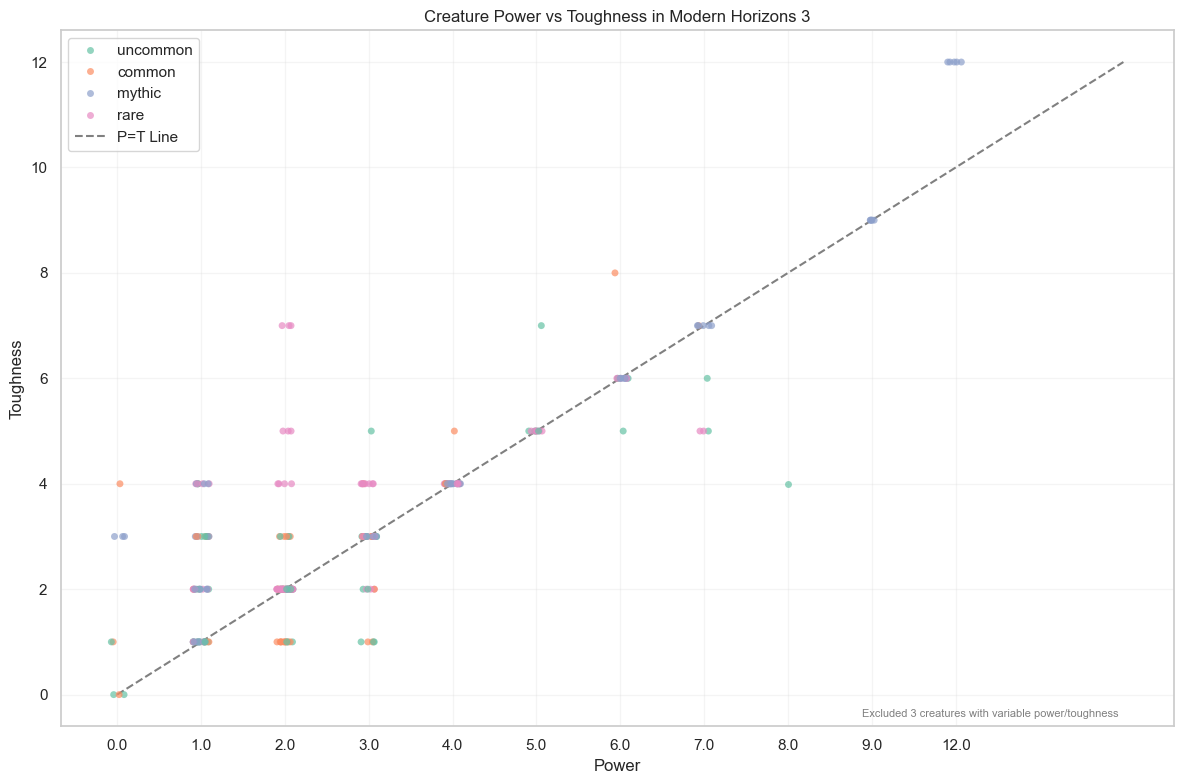

In [ ]:
creatures = mh3_df[mh3_df['types'].apply(lambda x: 'Creature' in x)].copy()

# 'p_num' to not conflict with 'power' column
creatures['p_num'] = pd.to_numeric(creatures['power'], errors='coerce')
creatures['t_num'] = pd.to_numeric(creatures['toughness'], errors='coerce')

# Filter out creatures with non-numeric power or toughness
var_cards = creatures[creatures['p_num'].isna() | creatures['t_num'].isna()]
var_count = len(var_cards)
print(f"Number of creatures with variable power/toughness: {var_count}")

creatures_clean = creatures.dropna(subset=['p_num', 't_num'])



## Come back to this later

### Part One: Scarcity

### How do people acquire Magic Cards?

*Magic* has been on the go since 1993. The primary way that *Magic* cards are released is through what are known as **Sets**. Cards are created usually with a specific artistic and fantastical theme and are group released together in a set. Sets then are sold through **booster boxes**, a number of randomly assigned cards placed into a box and sold on market, or in similar smaller collections known as **packs**. 

As *Magic* is a collectible card game, not all of the cards are readily available to the average consumer. Completing a set through booster boces or packs alone would require the purchase of a large quantity of sealed product. This scarcity incentivises trading between players - however more recently, the option to buy a single card online has grown in popularity. This secondary market provides a measureable proxy for card scarcity through observed prices. This will be analysed later.

### Why are some cards rarer than others?

If all cards are sold together in boxes or packs, why are other cards rarer than the others?

It has to do with three measurements:

1. Rarity Tiers
2. Print Frequency
3. Alpha and Beta Scarcity

### Sets Analysed

**Modern Horizons 3 (MH3)**, **Lord of the Rings (LTR)**, **Commander Masters (CMM)**, **Alpha (LEA)**, **Beta (LEB)**.

*The JSON files for these sets were provided by [`MTGJson`](https://mtgjson.com/), an open source project that catalogues MTG data.*